In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from matplotlib.cm import rainbow
import collections
from tqdm import tqdm_notebook as tqdm
import scipy.stats as sps
import pickle

import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output

%matplotlib inline

np.seterr(all='raise')
tfd = tfp.distributions

In [3]:
from datasets import *

In [4]:
data_set_small = load_data_set('./datasets/100.10')
data_set_big = load_data_set('./datasets/100.100')

In [5]:
from basic_solutions import *

evaluate(stupid_solution, data_set_small.train_data[0], data_set_small.val_data[0], data_set_small.ideal[0], data_set_small.L)

-0.05360327295709173

In [6]:
from tqdm import tqdm_notebook as tqdm

def super_puper_solution2(train, val, L):
    size = 3000
    m_ = np.random.uniform(0, 1, size=size)
    sum_ab_ = np.random.uniform(3, 1000, size=size)
    log_prob = []
    for i in (range(size)):
        m = m_[i]
        sum_ab = sum_ab_[i]
        alpha = m * sum_ab
        beta = (1 - m) * sum_ab
        log_prob.append(calc_bayesian_solve_loglike(alpha, beta, train, val, L))

    log_prob = np.array(log_prob) - np.max(log_prob)
    log_prob[log_prob < -30] = -30.
    prior_prob = np.exp(log_prob)
    p_pred = np.zeros_like(train, dtype=np.float32)
    
    for i in (range(size)):
        m = m_[i]
        sum_ab = sum_ab_[i]
        alpha = m * sum_ab
        beta = (1 - m) * sum_ab
        p_pred += bayesian_solve(alpha, beta, train + val, L * 2) * prior_prob[i]
    p_pred /= prior_prob.sum()
    return p_pred

In [7]:
def evaluate_compare(solutions, ds, plot=False, labels=[], best=True):
    llps = [[] for _ in solutions]
    for t_id in (range(ds.train_data.shape[0])):
        for i, solution in enumerate(solutions):
            score = evaluate(solution, ds.train_data[t_id], ds.val_data[t_id], ds.ideal[t_id], ds.L)
            if score != score or score == float('inf') or score == float('-inf'):
                print (t_id, i)
                raise Exception("unnormal score")
            llps[i].append(score)
    if best:
        llps.append([])
        labels.append("true")
        for t_id in range(ds.train_data.shape[0]):
            train = ds.train_data[t_id] + ds.val_data[t_id]
            p_pred = bayesian_solve(ds.alpha0[t_id], ds.beta0[t_id], train, 2 * ds.L)
            llps[-1].append(calc_llp(p_pred, train, ds.ideal[t_id], 2 * ds.L))


    min_ = 1e9
    max_ = -1e9
    ans = []
    
    good = np.ones(len(llps[0]), dtype=np.bool)
    for solution_scores in llps:
        sc = np.array(solution_scores)
        good &= sc == sc
        good &= sc != np.inf
        good &= sc != float("-inf")
    
    for solution_scores in llps:
        sc = np.array(solution_scores)
        #print (sc)
        ans.append((sc[good].mean(), good.sum()))
        min_ = min(min_, sc[good].min())
        max_ = max(max_, sc[good].max())

        
    if plot:
        for i, label in enumerate(labels):
            plt.hist(llps[i], bins=20, alpha=0.5, label=label + ", %.5f" % ans[i][0], range=(min_, max_))
        plt.ylabel('количество тестов', fontsize=18)
        plt.xlabel('llp', fontsize=18)
        plt.legend(title='# method, mean_score')
        plt.grid()
        plt.show()
        
    return ans

In [8]:
import pickle

In [11]:
def get_random_params():
    L = np.random.randint(2, 300)
    N = np.random.randint(2, 300)
    alpha = 0.1 + np.random.rand() * 500
    beta = 0.1 + np.random.rand() * 500
    return L, N, alpha, beta
    
def get_step_params(L, N, alpha, beta):
    L = np.clip(L + np.random.randint(-10, 10), 2, 300)
    N = np.clip(N + np.random.randint(-10, 10), 2, 300)
    alpha = np.clip(alpha + (np.random.rand() - 0.5) * 10, 0.1, 500)
    beta = np.clip(beta + (np.random.rand() - 0.5) * 10, 0.1, 500)
    return L, N, alpha, beta

In [ ]:
data = []
L, N, alpha, beta = get_random_params()
TEST_SZ = 100
ones = np.ones(TEST_SZ)

threshold = 0.001

for i in tqdm(range(1000000000)):    
    try:
        ds = DataSet(TEST_SZ, N, L, ones * alpha, ones * beta, random_seed=i)
    except ValueError as e:
        print (L, N, alpha, beta)
        print ("aaaa!!!!!")
        threshold /= 1.01
        L, N, alpha, beta = get_random_params()
        continue
    
    ans = evaluate_compare([
        max_loglike_solution,
        calibration_curve_solution
    ], ds, False, [], True)
    data.append((L, N, alpha, beta, ans))
    
    lscore = ans[1][0] - ans[0][0]
    tscore = ans[1][0] - ans[2][0]
    
    if lscore > threshold or tscore > threshold:
        threshold *= 1.01
        L, N, alpha, beta = get_step_params(L, N, alpha, beta)
    else:
        threshold /= 1.01
        L, N, alpha, beta = get_random_params()
    
    if i % 100 == 0:
        print (i, threshold)
        print (lscore, tscore, L, N, alpha, beta)

0 0.0009900990099009901
-0.00012452243813061616 -0.0007079158999126383 88 209 385.6611985151418 150.17078738955618
100 0.0009514656876067487
0.00032336380430677755 0.0002417622471191233 8 95 258.5138173197338 325.5382241765059
200 0.0007954417886979585
5.7847292883241724e-05 -2.0924356452456383e-05 286 245 31.509229756742133 21.66207445635903
300 0.0005449996197403559
1.3917568377302264e-05 -1.492055049094436e-05 244 254 330.92592572002496 266.02372637983626
400 0.0010936852726843613
0.00044826608974642395 0.0026748301940245703 24 166 31.428176329653517 490.4990587401286
500 0.0010303010000000002
0.00019610483727557602 -5.621894653454543e-06 76 288 335.0638298929488 227.48217388633304
600 0.0010721353521070103
7.54188363561465e-05 0.027580156316664238 2 257 262.7879837947165 8.983016394298447
15 197 236.0515820013332 0.01
aaaa!!!!!
74 269 365.03221119080666 0.01
aaaa!!!!!
700 0.0008963237175178051
6.845036765026208e-05 -1.9521726596818945e-05 219 234 228.9341101643261 252.2882472806643

In [20]:
len(data)

8015

In [30]:
import pickle

with open('dump', 'wb') as f:
    pickle.dump(data, f)

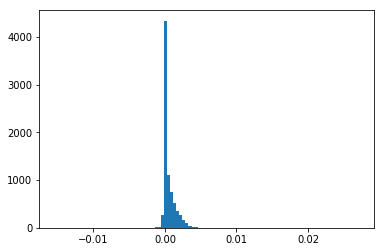

In [25]:
plt.hist([d[4][1][0] - d[4][0][0] for d in data], bins=100)
plt.show()

In [34]:
dc = np.array([d[4][1][0] for d in data])
dt = np.array([d[4][2][0] for d in data])
dm = np.array([d[4][0][0] for d in data])

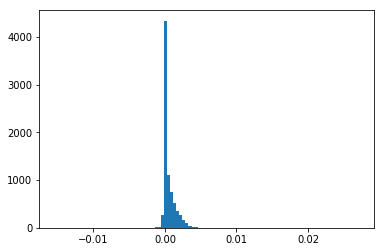

In [36]:
plt.hist(dc - dm, bins=100)
plt.show()

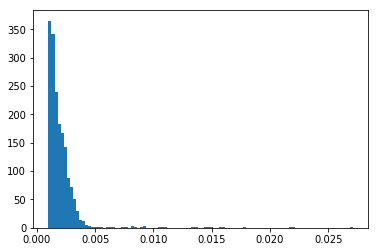

In [43]:
good = (dc - dm > 0.001)
plt.hist(dc[good] - dm[good], bins=100)
plt.show()

In [44]:
Ls = np.array([d[0] for d in data])
Ns = np.array([d[1] for d in data])
As = np.array([d[2] for d in data])
Bs = np.array([d[3] for d in data])

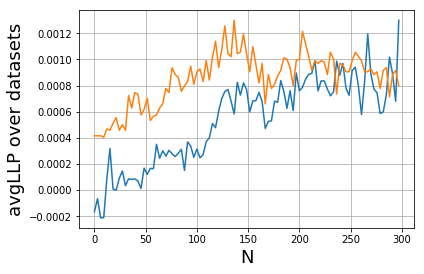

In [145]:
sz = 100
space = np.linspace(0, 300, sz)
diff = dc - dm
gr = []
gr2 = []
for i in range(sz - 1):
    goods = np.logical_and(Ns > space[i], Ns < space[i + 1])
    gr.append(diff[goods].mean())
    gr2.append(goods.sum())

plt.plot(space[:-1], gr)
plt.plot(space[:-1], gr2 / max(gr2) * max(gr))
plt.xlabel('N', fontsize=18)
plt.ylabel('avgLLP over datasets', fontsize=18)
plt.grid()
plt.show()

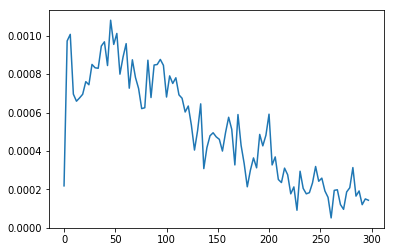

In [104]:
sz = 100
space = np.linspace(0, 300, sz)
diff = dc - dm
gr = []
for i in range(sz - 1):
    goods = np.logical_and(Ls > space[i], Ls < space[i + 1])
    gr.append(diff[goods].mean())
    
plt.plot(space[:-1], gr)
plt.show()

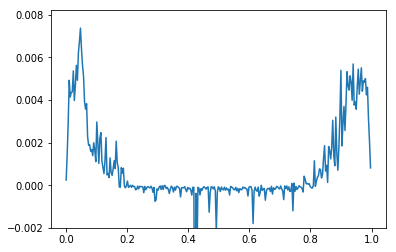

In [112]:
sz = 300
space = np.linspace(0, 1, sz)
diff = dc - dt
gr = []
v = As / (As + Bs)
for i in range(sz - 1):
    goods = np.logical_and(v > space[i], v < space[i + 1])
    if goods.sum() == 0:
        gr.append(0)
    else:
        gr.append(diff[goods].mean())
    
plt.plot(space[:-1], gr)
plt.ylim((-0.002, None))
plt.show()

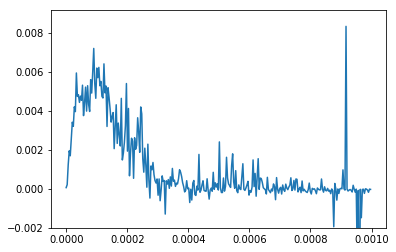

In [129]:
sz = 300
space = np.linspace(0, 0.001, sz)
diff = dc - dt
gr = []
v = As * Bs / (As + Bs) / (As + Bs) / (As + Bs + 1)
for i in range(sz - 1):
    goods = np.logical_and(v > space[i], v < space[i + 1])
    #print (goods.sum())
    if goods.sum() == 0:
        gr.append(0)
    else:
        gr.append(diff[goods].mean())
    
plt.plot(space[:-1], gr)
plt.ylim((-0.002, None))
plt.show()

In [114]:
good = As / (As + Bs) < 0.08
good = np.logical_and(good, As / (As + Bs) > 0.02)
good = np.logical_and(good, Ls > 30)
good = np.logical_and(good, Ls < 50)
good = np.logical_and(good, Ns > 200)
good = np.logical_and(good, Ns > 30)
(dc - dt)[good].mean(), good.sum()

(0.0021435783579890084, 79)

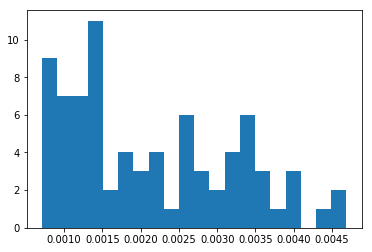

In [118]:
plt.hist((dc - dt)[good], bins=20)
plt.show()

In [ ]:
def grid(Ass, Bss, Lss, Nss):
    for a in range(len(Ass) - 1):
        for a in range(len(Bss) - 1):
            for a in range(len(Lss) - 1):
                for a in range(len(Nss) - 1):

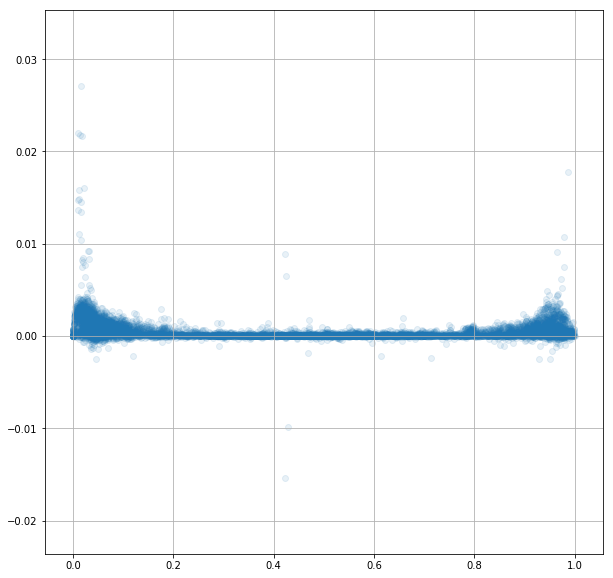

In [102]:
plt.figure(figsize=(10, 10))
plt.scatter(As / (As + Bs), dc - dm, alpha=0.1)
plt.grid()
plt.show()

In [54]:
def paint_(a, b, threshold):
    good = (dc - dm > threshold)
    plt.scatter(a[good], b[good])
    plt.scatter(a[np.logical_not(good)], b[np.logical_not(good)], alpha=0.1)
    plt.show()

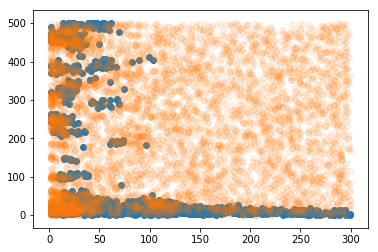

In [56]:
paint_(Ls, As, 0.001)

In [ ]:
good = (dc - dm > 0.002)
plt.scatter(Ls[good], Bs[good])
plt.scatter(Ls[np.logical_not(good)], Bs[np.logical_not(good)], alpha=0.1)

In [60]:
import pandas as pd
import plotly
import plotly.graph_objs as go

In [151]:

markercolor = (dc - dm) * 100

down = np.quantile(markercolor, 0.6)
up = np.quantile(markercolor, 0.9)

markercolor = np.clip(markercolor, down, up)

good = np.logical_and(markercolor > down, markercolor < up)

#Make Plotly figure
fig1 = go.Scatter3d(x=(As / (As + Bs))[good],
                    y=Ns[good],
                    z=Ls[good],
                    marker=dict(color=markercolor[good],
                                opacity=1,
                                reversescale=True,
                                colorscale='Blues',
                                size=2),
                    line=dict (width=0.02),
                    mode='markers')

mylayout = go.Layout(scene=dict(xaxis=dict( title="α / (α + β)"),
                                yaxis=dict( title="N"),
                                zaxis=dict(title="L")),)

plotly.offline.plot({"data": [fig1],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("4DPlot2.html"))


'4DPlot2.html'

In [62]:
! ls

10_10				     datasets.py
10_120				     dump
10_30				     f
10_300				     graph_params.png
10_70				     hmc
=1.12.0				     hmc-all01.ipynb
120_10				     hmc_burnin_size.ipynb
120_120				     hmc-Copy1.ipynb
120_30				     hmc.ipynb
120_300				     hmc_sampling.ipynb
120_70				     hmc-stress.ipynb
18-AUTOML-RGPE.pdf		     Kolesnikov-2012-master-thesis(1).pdf
300_10				     max_loglike_method_generation-Copy1.ipynb
300_120				     max_loglike_method_generation.ipynb
300_30				     methods_and_compare_generation-Copy1.ipynb
300_300				     methods_and_compare_generation.ipynb
300_70				     methods_and_compare_grid.ipynb
30_10				     methods_and_compare_lab.ipynb
30_120				     plot_calibration_curve.ipynb
30_30				     plot_calibration_curve-MY.ipynb
30_300				     Popovkin_task_defence_2.0.pdf
30_70				     pracanalHW6-normal-dataset.ipynb
4DPlot.html			     ps_model(1).ipynb
70_10				     ps_model(2)-Copy1.ipynb
70_120				     ps_model(2).ipynb
70_30				     __pycache__
70_300	

10 10


-0.02289161380886059 0.1395520512263941
-0.021579507539043204 0.15142193164173706
-0.05936186485252686 0.13555480393402297


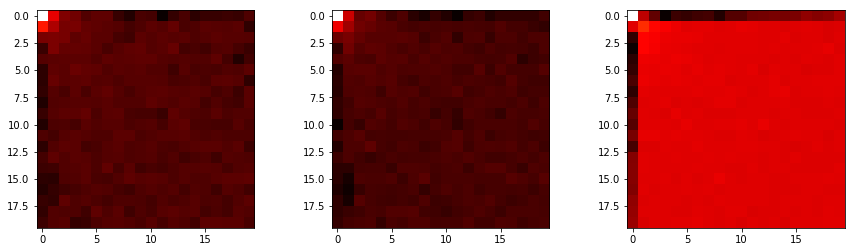

10 30


-0.013901606791373759 0.16453404393548973
-0.014418697365880806 0.17299817460271685
-0.0539305142849539 0.14437184134151695


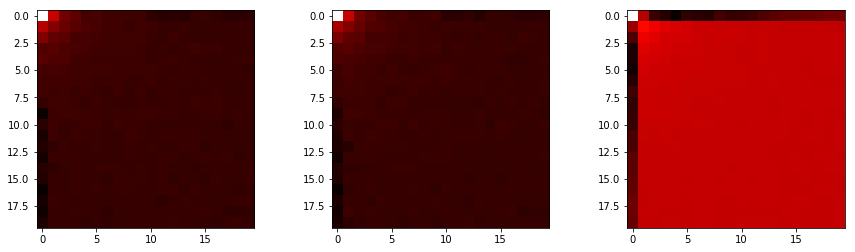

10 70


-0.005861228473146812 0.16889375453797084
-0.00604160733180734 0.17149978092832466
-0.049824055748623725 0.14873385426754204


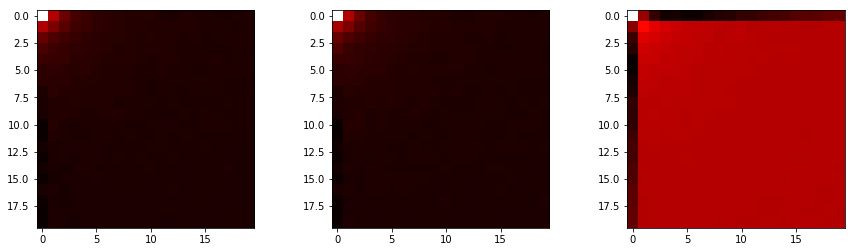

10 120


-0.006201080392962441 0.17399863015974412
-0.004480409593279304 0.17323502569004715
-0.051857533935845135 0.14629128842767045


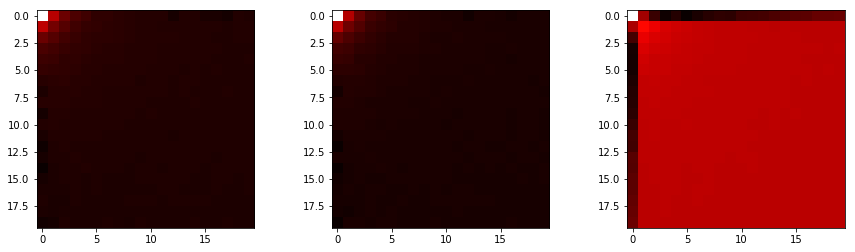

10 300


-0.03404073754631264 0.15549699360104477
-0.004713633880871463 0.1677700858935694
-0.04934259986378533 0.14457301258395247


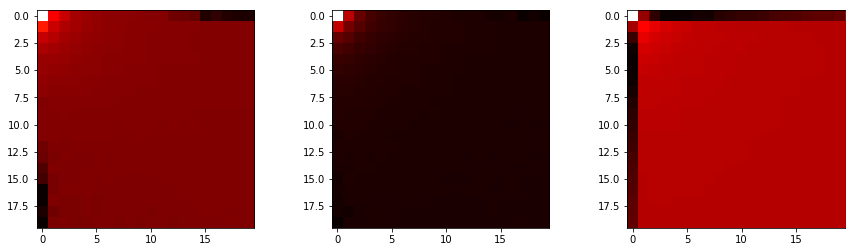

30 10


In [ ]:
IV = 0
TEST_SZ = 30
all_data = []
for L in tqdm([10, 30, 70, 120, 300]):
    for n in tqdm([10, 30, 70, 120, 300]):
        print (L, n)
        data = []
        A = np.linspace(1, 100, 20)
        ones = np.ones(TEST_SZ)
        for alpha in tqdm(A):
            data.append([])
            for beta in A:
                IV += 1
                ans = evaluate_compare([
                    max_loglike_solution,
                    calibration_curve_solution
                ], DataSet(TEST_SZ, n, L, ones * alpha, ones * beta, random_seed=IV), False, [], True)
                data[-1].append([a[0] for a in ans])
        data = np.array(data)
        plt.figure(figsize=(15, 4))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            d = data[:,:,i].copy()
            print (d.min(), d.max())
            d -= d.min()
            d /= d.max()
            plt.imshow(d, cmap='hot', interpolation='nearest')
        plt.show()
        with open(str(L) + "_" + str(n), 'wb') as f:
            pickle.dump((L, n, data), f)
        all_data.append(data)